---
layout: post  
---

In [2]:
function viterbi_maximum_likelihood_traversals(stranded_kmer_graph;
                                               error_rate::Float64=1/(stranded_kmer_graph.gprops[:k] + 1),
                                               verbosity::String="dataset")
    @assert verbosity in ["debug", "reads", "dataset"]
    if error_rate >= .5
        error("Error rate >= 50%. Did you enter the accuracy by mistake?")
    end

    if verbosity in ["debug", "reads", "dataset"]
        println("computing kmer counts...")
    end
    stranded_kmer_counts = [length(stranded_kmer_graph.vprops[vertex][:coverage]) for vertex in vertices(stranded_kmer_graph)]
    if verbosity in ["debug", "reads", "dataset"]
        println("computing kmer state likelihoods...")
    end
    stranded_kmer_likelihoods = stranded_kmer_counts ./ sum(stranded_kmer_counts)
    accuracy = 1 - error_rate

    if verbosity in ["debug"]
        println("STATE LIKELIHOODS:")
        println("\tkmer\tcount\tlikelihood")
        for vertex in vertices(stranded_kmer_graph)
            kmer = stranded_kmer_graph.gprops[:stranded_kmers][vertex]
            count = stranded_kmer_counts[vertex]
            likelihood = stranded_kmer_likelihoods[vertex]
            println("\t$kmer\t$count\t$likelihood")
        end
    end
    if verbosity in ["debug", "reads", "dataset"]
        println("finding shortest paths between kmers...")
    end
    shortest_paths = enumerate_paths(floyd_warshall_shortest_paths(stranded_kmer_graph))
    K = stranded_kmer_graph.gprops[:K]
    for K1 in 1:K
        for K2 in 1:K
            if K1 != K2
                shortest_path = shortest_paths[K1][K2]
                path_likelihood = 1.0
                for ui in 1:length(shortest_path)-1
                    u = shortest_path[ui]
                    v = shortest_path[ui + 1]
                    # likelihood of the transition
                    path_likelihood *= edge_probability(stranded_kmer_graph, Edge(u, v))
                end
                if path_likelihood == 0.0
                    shortest_paths[K1][K2] = Vector{Int}()
                end
            elseif K1 == K2
                # the shortest path from a kmer to itself is an insertion (no edge)
                # so need to manually check for self loops
                if has_edge(stranded_kmer_graph, Edge(K1, K2))
                    if edge_probability(stranded_kmer_graph, Edge(K1, K2)) != 0.0
                        shortest_paths[K1][K2] = [K1, K2]
                    else
                        shortest_paths[K1][K2] = Vector{Int}()
                    end
                # otherwise, check to see if any outneighbors connect back to the kmer
                else
                    connected_outneighbors = filter(outneighbor -> has_path(stranded_kmer_graph, outneighbor, K2), outneighbors(stranded_kmer_graph, K1))
                    if !isempty(connected_outneighbors)
                        outneighbor_cycles = [[K1, shortest_paths[outneighbor][K2]...] for outneighbor in connected_outneighbors]
                        cycle_likelihoods = ones(length(outneighbor_cycles))
                        for (i, cycle) in enumerate(outneighbor_cycles)
                            for ui in 1:length(cycle)-1
                                u = cycle[ui]
                                v = cycle[ui + 1]
                                # likelihood of the transition
                                cycle_likelihoods[i] *= edge_probability(stranded_kmer_graph, Edge(u, v))
                            end
                            # include likelihoods of states
                            for vertex in cycle[2:end-1]
                                cycle_likelihoods[i] *= stranded_kmer_likelihoods[vertex]
                            end
                        end
                        path_likelihood = maximum(cycle_likelihoods)
                        max_likelihood_cycle_indices = findall(cycle_likelihoods .== path_likelihood)
                        shortest_paths[K1][K2] = outneighbor_cycles[first(max_likelihood_cycle_indices)]
                    else
                        shortest_paths[K1][K2] = Vector{Int}()
                    end
                end
            end
            if length(shortest_paths[K1][K2]) == 1
                shortest_paths[K1][K2] = Vector{Int}()
            end
        end
    end

    if verbosity in ["debug"]
        for K1 in 1:K
            for K2 in 1:K
                println("\t$K1\t$K2\t$(shortest_paths[K1][K2])")
            end
        end
    end

    total_bases_observed = 0
    total_edits_accepted = 0

    corrected_observations = FASTA.Record[]
    if verbosity in ["debug", "reads", "dataset"]
        println("finding viterbi maximum likelihood paths for observed sequences...")
    end
    # p = Progress(length(stranded_kmer_graph.gprops[:observed_paths]))
    for (observation_index, observed_path) in enumerate(stranded_kmer_graph.gprops[:observed_paths])
        if verbosity in ["debug", "reads"]
            println("\nevaluating sequence $observation_index of $(length(stranded_kmer_graph.gprops[:observed_paths]))")
        end
        # consider switching to log transform
        kmer_likelihoods = zeros(nv(stranded_kmer_graph), length(observed_path))
        kmer_arrival_paths = Array{Vector{Int}}(undef, nv(stranded_kmer_graph), length(observed_path))
        edit_distances = zeros(Int, nv(stranded_kmer_graph), length(observed_path))
        observed_kmer_index = observed_path[1]
        observed_kmer_sequence = stranded_kmer_graph.gprops[:stranded_kmers][observed_kmer_index]
        for hidden_kmer_index in vertices(stranded_kmer_graph)
            hidden_kmer_sequence = stranded_kmer_graph.gprops[:stranded_kmers][hidden_kmer_index]
            alignment_result = pairalign(LevenshteinDistance(), observed_kmer_sequence, hidden_kmer_sequence)
            number_of_matches = count_matches(alignment(alignment_result))
            number_of_edits = stranded_kmer_graph.gprops[:k] - number_of_matches
            kmer_likelihoods[hidden_kmer_index, 1] = stranded_kmer_likelihoods[hidden_kmer_index]
            for match in 1:number_of_matches
                kmer_likelihoods[hidden_kmer_index, 1] *= accuracy
            end
            for edit in 1:number_of_edits
                kmer_likelihoods[hidden_kmer_index, 1] *= error_rate
            end
            kmer_arrival_paths[hidden_kmer_index, 1] = Vector{Int}()
            edit_distances[hidden_kmer_index, 1] = number_of_edits
        end
        kmer_likelihoods[:, 1] ./= sum(kmer_likelihoods[:, 1])
        # from here on, all probabilities are log transformed
        kmer_likelihoods[:, 1] .= log.(kmer_likelihoods[:, 1])
        if verbosity in ["debug"]
            println("\tconsidering path state 1")
            println("\t\tobserved kmer $observed_kmer_sequence")
            println("\t\tInitial state log likelihoods:")
            for line in split(repr(MIME("text/plain"), kmer_likelihoods[:, 1]), '\n')
                println("\t\t\t$line")
            end
        end
        for observed_path_index in 2:length(observed_path)
            observed_kmer_index = observed_path[observed_path_index]
            observed_base = stranded_kmer_graph.gprops[:stranded_kmers][observed_kmer_index][end]

            if verbosity in ["debug"]
                println("\tconsidering path state $observed_path_index")
                println("\t\tobserved base $observed_base")
            end

            MATCH = 1
            MISMATCH = 2
            DELETION = 3
            INSERTION = 4
            arrival_likelihoods = ones(K, 4)
            arrival_paths = fill(Vector{Int}(), K, 4)

            for K2 in 1:K
                kmer_base = stranded_kmer_graph.gprops[:stranded_kmers][K2][end]
                base_is_match = kmer_base == observed_base

                maximum_likelihood = log(0.0)
                maximum_likelihood_path = Vector{Int}()
                maximum_likelihood_edit_distance = 0

                for K1 in 1:K
                    shortest_path = shortest_paths[K1][K2]
                    if length(shortest_path) >= 2
                        edit_distance = Int(!base_is_match) + length(shortest_path) - 2
                        if edit_distance == 0
                            p = kmer_likelihoods[K1, observed_path_index-1] +
                                log(accuracy) + log(stranded_kmer_likelihoods[K2])
                        else
                            p = kmer_likelihoods[K1, observed_path_index-1] +
                                log(error_rate^edit_distance) + log(stranded_kmer_likelihoods[K2])
                        end
                        edit_distance += edit_distances[K1, observed_path_index-1]
                    else
                        p = log(0.0)
                    end
                    if K1 == K2 # consider insertion
                        # in theory, I don't think we should care if the base
                        # matches or not because it's an inserted & erroneous
                        # base, but in practice it's necessary to balance
                        # insertion probabilities with deletion probabilities
                        insertion_p = kmer_likelihoods[K1, observed_path_index-1] +
                                      log(error_rate^(1 + Int(!base_is_match))) + log(stranded_kmer_likelihoods[K2])
                        if insertion_p > p
                            p = insertion_p
                            edit_distance = edit_distances[K1, observed_path_index-1] + 1
                            shortest_path = [K2]
                        end
                    end
                    if p > maximum_likelihood
                        maximum_likelihood = p
                        maximum_likelihood_path = shortest_path
                        maximum_likelihood_edit_distance = edit_distance
                    end
                end
                kmer_likelihoods[K2, observed_path_index] = maximum_likelihood
                kmer_arrival_paths[K2, observed_path_index] = maximum_likelihood_path
                edit_distances[K2, observed_path_index] = maximum_likelihood_edit_distance
            end

            if verbosity in ["debug"]
                println("\t\tkmer log likelihoods")
                for line in split(repr(MIME("text/plain"), kmer_likelihoods), '\n')
                    println("\t\t\t$line")
                end
                println("\t\tarrival paths")
                for line in split(repr(MIME("text/plain"), kmer_arrival_paths), '\n')
                    println("\t\t\t$line")
                end
            end
        end

        if verbosity in ["debug"]
            println("\n\tInputs for viterbi maximum likelihood traversal evaluation:")
            println("\t\tkmer log likelihoods")
            for line in split(repr(MIME("text/plain"), kmer_likelihoods), '\n')
                println("\t\t\t$line")
            end
            println("\t\tkmer arrival paths")
            for line in split(repr(MIME("text/plain"), kmer_arrival_paths), '\n')
                println("\t\t\t$line")
            end
            println("\t\tedit distances")
            for line in split(repr(MIME("text/plain"), edit_distances), '\n')
                println("\t\t\t$line")
            end
        end

        ## backtrack
        maximum_likelihood_path_value = maximum(kmer_likelihoods[:, end])
        maximum_likelihood_path_indices = findall(kmer_likelihoods[:, end] .== maximum_likelihood_path_value)
        # if multiple paths are tied, randomly choose one
        maximum_likelihood_path_index = rand(maximum_likelihood_path_indices)
        maximum_likelihood_edit_distance = edit_distances[maximum_likelihood_path_index, end]

        if length(kmer_arrival_paths[maximum_likelihood_path_index, end]) > 0
            maximum_likelihood_path = last(kmer_arrival_paths[maximum_likelihood_path_index, end])
            for observed_path_index in length(observed_path):-1:1
                maximum_likelihood_arrival_path = kmer_arrival_paths[maximum_likelihood_path_index, observed_path_index]
                maximum_likelihood_path = vcat(maximum_likelihood_arrival_path[1:end-1], maximum_likelihood_path)
                maximum_likelihood_path_index = first(maximum_likelihood_path)
            end
        else
            maximum_likelihood_path = [maximum_likelihood_path_index]
        end
        observed_sequence = path_to_sequence(stranded_kmer_graph.gprops[:stranded_kmers], observed_path)
        maximum_likelihood_sequence = path_to_sequence(stranded_kmer_graph.gprops[:stranded_kmers], maximum_likelihood_path)
        if verbosity in ["debug", "reads"]
            println("\tobserved sequence                 $observed_sequence")
            println("\tmaximum likelihood sequence       $maximum_likelihood_sequence")
            println("\tmaximum likelihood edit distance  $maximum_likelihood_edit_distance")
        end
        total_bases_observed += length(observed_sequence)
        total_edits_accepted += maximum_likelihood_edit_distance
        id = stranded_kmer_graph.gprops[:observation_ids][observation_index]
        kmer_stamped_id = id * "_" * string(stranded_kmer_graph.gprops[:k])
        push!(corrected_observations, FASTA.Record(kmer_stamped_id, maximum_likelihood_sequence))
        # progress meter
        # next!(p)
    end
    if verbosity in ["debug", "reads", "dataset"]
        println("\nDATASET STATISTICS:")
        println("\tassumed error rate    $(error_rate * 100)%")
        println("\ttotal bases observed  $total_bases_observed")
        println("\ttotal edits accepted  $total_edits_accepted")
        println("\tinferred error rate   $((total_edits_accepted/total_bases_observed) * 100)%")
    end
    return corrected_observations
end

viterbi_maximum_likelihood_traversals (generic function with 1 method)

In [3]:
import Pkg
pkgs = [
    "BioSequences",
    "Random",
    "BenchmarkTools",
    "Primes",
    "LightGraphs",
    "StatsBase",
    "DataStructures",
    "GraphRecipes",
    "Plots",
    "BioSymbols",
    "StatsPlots",
    "BioAlignments",
    "SparseArrays"
]

Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [4]:
function get_kmer_counts(::Type{KMER_TYPE}, sequence) where KMER_TYPE
    raw_kmer_counts = StatsBase.countmap(BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(KMER_TYPE, sequence))
    kmer_counts = convert(Dict{KMER_TYPE, Int}, raw_kmer_counts)
    return sort(kmer_counts)
end

get_kmer_counts (generic function with 1 method)

In [5]:
function get_kmer_index(kmers, kmer)
    index_range = searchsorted(kmers, kmer)
    if !isempty(index_range)
        return first(index_range)
    else
        return nothing
    end
end

get_kmer_index (generic function with 1 method)

In [6]:
function observe(sequence; error_rate = error_rate, alphabet = BioSymbols.ACGT)
    new_seq = Vector{eltype(sequence)}()
    for character in sequence
        if rand() > error_rate
            # match
            push!(new_seq, character)
        else
            error_type = rand(1:3)
            if error_type == 1
                # mismatch
                push!(new_seq, rand(setdiff(alphabet, character)))
            elseif error_type == 2
                # insertion
                push!(new_seq, rand(alphabet))
                push!(new_seq, character)
            else
                # deletion
                continue
            end
        end
    end
    return_seq = BioSequences.LongDNASeq(new_seq)
    if rand(Bool)
        return_seq = BioSequences.reverse_complement!(return_seq)
    end
    return return_seq
end

observe (generic function with 1 method)

In [7]:
function ordered_edge(a, b)
    if a <= b
        return LightGraphs.Edge(a, b)
    else
        return LightGraphs.Edge(b, a)
    end
end

ordered_edge (generic function with 1 method)

In [8]:
function initialize_graph(observations, kmers, k)
    # initalize graph
    graph = LightGraphs.SimpleGraph(length(kmers))
    
    EDGE_TYPE = LightGraphs.SimpleGraphs.SimpleEdge{Int}

    # an individual piece of evidence takes the form of
    # (observation_index = observation #, edge_index = edge # starting from beginning of the observation)

    EVIDENCE_TYPE = NamedTuple{(:observation_index, :edge_index),Tuple{Int64,Int64}}
    
    # evidence takes the form of Edge => [(evidence_1), (evidence_2), ..., (evidence_N)]    
    edge_evidence = Dict{EDGE_TYPE, Vector{EVIDENCE_TYPE}}()
    for (observation_index, observation) in enumerate(observations)
        for edge_index in 1:length(observation)-k
            a_to_b_connection = observation[edge_index:edge_index+k]
            a = BioSequences.canonical(BioSequences.DNAMer(a_to_b_connection[1:end-1]))
            b = BioSequences.canonical(BioSequences.DNAMer(a_to_b_connection[2:end]))
            a_index = get_kmer_index(kmers, a)
            b_index = get_kmer_index(kmers, b)
            edge = ordered_edge(a_index, b_index)
            LightGraphs.add_edge!(graph, edge)
            evidence = (;observation_index, edge_index)
            edge_evidence[edge] = push!(get(edge_evidence, edge, EVIDENCE_TYPE[]), evidence)
        end
    end
    return (graph = graph, edge_evidence = edge_evidence)
end

initialize_graph (generic function with 1 method)

In [9]:
function determine_edge_probabilities(graph, kmers, edge_evidence)
    outgoing_edge_probabilities = determine_edge_probabilities(graph, kmers, edge_evidence, true)
    incoming_edge_probabilities = determine_edge_probabilities(graph, kmers, edge_evidence, false)
    return outgoing_edge_probabilities, incoming_edge_probabilities
end

function determine_edge_probabilities(graph, kmers, edge_evidence, strand)
    outgoing_edge_probabilities = SparseArrays.spzeros(length(kmers), length(kmers))
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbor_indices = Union{Nothing, Int}[
            get_kmer_index(kmers, BioSequences.canonical(neighbor)) for neighbor in BioSequences.neighbors(kmer)
        ]
        # kmer must be in our dataset
        filter!(neighbor_index -> neighbor_index != nothing, downstream_neighbor_indices)
        # must have edge between kmers
        filter!(neighbor_index -> LightGraphs.has_edge(graph, ordered_edge(kmer_index, neighbor_index)), downstream_neighbor_indices)
        sort!(downstream_neighbor_indices)
        
        downstream_edge_weights = Int[
            length(get(edge_evidence, ordered_edge(kmer_index, neighbor_index), [])) for neighbor_index in downstream_neighbor_indices
        ]
        
        non_zero_indices = downstream_edge_weights .> 0
        downstream_neighbor_indices = downstream_neighbor_indices[non_zero_indices]
        downstream_edge_weights = downstream_edge_weights[non_zero_indices]
        
        downstream_edge_likelihoods = downstream_edge_weights ./ sum(downstream_edge_weights)
        for (neighbor_index, likelihood) in zip(downstream_neighbor_indices, downstream_edge_likelihoods)
            outgoing_edge_probabilities[kmer_index, neighbor_index] = likelihood
        end
    end
    return outgoing_edge_probabilities
end

determine_edge_probabilities (generic function with 2 methods)

In [10]:
function plot_graph(graph, kmers, counts)
    graph_hash = hash(sort(graph.graph.fadjlist), hash(graph.graph.ne))

    p = GraphRecipes.graphplot(
        graph.graph,
        names = 1:length(kmers),
        node_weights = counts,
        markersize = 0.2,
        hover=false,
        fontsize=12)

    filename = "/assets/images/$(graph_hash).svg"
    Plots.savefig(p, dirname(pwd()) * filename)
    display(p)
    display("text/markdown", "![]($filename)")
end

plot_graph (generic function with 1 method)

In [11]:
function assess_alignment(a, b)
    pairwise_alignment = BioAlignments.pairalign(BioAlignments.LevenshteinDistance(), a, b)
    alignment_result = BioAlignments.alignment(pairwise_alignment)
    total_aligned_bases = BioAlignments.count_aligned(alignment_result)
    total_matches = BioAlignments.count_matches(alignment_result)
    total_edits = total_aligned_bases - total_matches
    return (;total_matches, total_edits)
end

assess_alignment (generic function with 1 method)

In [175]:
function assess_path_orientations(path, kmers, initial_orientation)
    
    ORIENTATION_TYPE = Union{Bool, Missing}
    
    orientations = Vector{ORIENTATION_TYPE}(missing, length(path))
    orientations[1] = true
    
    for (i, (a, b)) in enumerate(zip(path[1:end-1], path[2:end]))
        kmer_a = kmers[a]
        kmer_b = kmers[b]
        forward_match = all(kmer_a[a_index] == kmer_b[b_index] for (a_index, b_index) in zip(2:length(kmer_a), 1:length(kmer_b)-1))
        reverse_match = all(kmer_a[a_index] == BioSequences.reverse_complement(kmer_b)[b_index] for (a_index, b_index) in zip(2:length(kmer_a), 1:length(kmer_b)-1))
        if forward_match && reverse_match
            # ambiguous orientation
            this_orientation = missing
        elseif forward_match && !reverse_match
            this_orientation = true
        elseif !forward_match && reverse_match
            this_orientation = false
        else
            @error "neither orientation matches $kmer_a, $kmer_b"
        end
        orientations[i+1] = this_orientation
    end
    if !ismissing(initial_orientation) && !initial_orientation
        # if all orientations are missing, this will drop the Union{Bool, Missing} type and just become Missing
        # convert to enforce the type we want
        orientations = convert(Vector{ORIENTATION_TYPE}, .!orientations)
    end
#     @show typeof(orientations)
    return orientations
end

assess_path_orientations (generic function with 1 method)

In [13]:
function assess_path_likelihood(oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
    # we take it as a given that we are at the current node, so initialize with p=1 and then update with other node likelihoods
    likelihood = 1.0
    total_kmer_count = sum(counts)
    for node in oriented_path[2:end]
        likelihood *= counts[node.index] / total_kmer_count
    end
    for (a, b) in zip(oriented_path[1:end-1], oriented_path[2:end])
        if ismissing(a.orientation)
            # ambiguous orientation
            likelihood *= max(incoming_edge_probabilities[a.index, b.index], incoming_edge_probabilities[a.index, b.index])
        elseif a.orientation
            likelihood *= outgoing_edge_probabilities[a.index, b.index]
        elseif !a.orientation
            likelihood *= incoming_edge_probabilities[a.index, b.index]
        else
            @error "unreachable condition"
        end
    end
    return likelihood
end

assess_path_likelihood (generic function with 1 method)

In [14]:
function orient_path(path, orientations)
    oriented_path = [(index = i, orientation = o) for (i, o) in zip(path, orientations)] 
    return oriented_path
end

orient_path (generic function with 1 method)

In [15]:
function assess_emission(current_orientation, current_kmer_index, observed_kmer, kmers)
    current_kmer = kmers[current_kmer_index]
    
    forward_emission_match = current_kmer[end] == observed_kmer[end]
    reverse_emission_match = BioSequences.reverse_complement(current_kmer)[end] == observed_kmer[end]
    
    if !ismissing(current_orientation) && current_orientation
        emission_match = forward_emission_match
        evaluated_orientation = current_orientation
    elseif !ismissing(current_orientation) && !current_orientation
        emission_match = reverse_emission_match
        evaluated_orientation = current_orientation
    elseif ismissing(current_orientation)
        # ambiguous orientation
        if forward_emission_match && !reverse_emission_match
            emission_match = forward_emission_match
            evaluated_orientation = true
        elseif !forward_emission_match && reverse_emission_match
            emission_match = reverse_emission_match
            evaluated_orientation = false
        elseif forward_emission_match && reverse_emission_match
            @warn "is this possible?"
            @show current_kmer, observed_kmer
            emission_match = true
            evaluated_orientation = missing
        elseif !forward_emission_match && !reverse_emission_match
            emission_match = false
            evaluated_orientation = missing
        end
    else
        @error "unreachable condition"
    end
    return (emission_match = emission_match, evaluated_orientation = evaluated_orientation)
end

assess_emission (generic function with 1 method)

In [150]:
function assess_path(path, 
    kmers,
    counts,
    initial_orientation,
    outgoing_edge_probabilities,
    incoming_edge_probabilities,
    error_rate)
    
    orientations = assess_path_orientations(path, kmers, initial_orientation)
    emission_match, evaluated_orientation = assess_emission(last(orientations), last(path), observed_kmer, kmers)
    # assert an orientation if we found one
    if ismissing(last(orientations)) && !ismissing(evaluated_orientation)
        orientations[end] = evaluated_orientation
    end
    oriented_path = orient_path(path, orientations)
    path_likelihood = assess_path_likelihood(oriented_path, kmers, counts, outgoing_edge_probabilities, incoming_edge_probabilities)
    path_likelihood *= emission_match ? (1.0 - error_rate) : error_rate
    edit_distance = !emission_match + abs(length(path) - 2)
    
    return (oriented_path = oriented_path, path_likelihood = path_likelihood, edit_distance = edit_distance)    
end

assess_path (generic function with 1 method)

In [61]:
function find_outneighbors(orientation, kmer_index, outgoing_edge_probabilities, incoming_edge_probabilities)
    if ismissing(orientation)
        outneighbors = vcat(
            first(SparseArrays.findnz(outgoing_edge_probabilities[kmer_index, :])),
            first(SparseArrays.findnz(incoming_edge_probabilities[kmer_index, :]))
        )
    elseif orientation
        outneighbors = first(SparseArrays.findnz(outgoing_edge_probabilities[kmer_index, :]))
    else
        outneighbors = first(SparseArrays.findnz(incoming_edge_probabilities[kmer_index, :]))
    end
    return outneighbors
end

find_outneighbors (generic function with 1 method)

In [18]:
function assess_insertion(previous_orientation, current_kmer_index, observed_kmer, kmers, counts, error_rate)
    
    transition_likelihood = error_rate
    state_likelihood = counts[current_kmer_index] / sum(counts)
    emission_match, evaluated_orientation = assess_emission(previous_orientation, current_kmer_index, observed_kmer, kmers)
    
    oriented_path = ORIENTED_KMER[(index = current_kmer_index, orientation = evaluated_orientation)]
    
    emission_likelihood = emission_match ? (1.0 - error_rate) : error_rate
    path_likelihood = state_likelihood * transition_likelihood * emission_likelihood
    
    transition_edit_distance = 1
    edit_distance = !emission_match + transition_edit_distance
    
    return (oriented_path = oriented_path, path_likelihood = path_likelihood, edit_distance = edit_distance)
end

assess_insertion (generic function with 1 method)

In [194]:
function find_optimal_path(observed_kmer,
    previous_kmer_index,
    previous_orientation,
    current_kmer_index,
    graph, 
    shortest_paths, 
    kmers, 
    counts, 
    outgoing_edge_probabilities, 
    incoming_edge_probabilities,
    error_rate)

    path_likelihood = 0.0
    oriented_path = Vector{ORIENTED_KMER}()
    edit_distance = 0

    if current_kmer_index == previous_kmer_index
        # could be true connection, check this first
        if LightGraphs.has_edge(graph, LightGraphs.Edge(previous_kmer_index, current_kmer_index))
            this_path = [previous_kmer_index, current_kmer_index]
            this_oriented_path, this_likelihood, this_edit_distance = 
                assess_path(this_path, 
                            kmers,
                            counts,
                            previous_orientation,
                            outgoing_edge_probabilities,
                            incoming_edge_probabilities,
                            error_rate)
            @show "match"
            @show this_oriented_path
            @show this_likelihood
            @show this_edit_distance
            if this_likelihood > path_likelihood
                path_likelihood = this_likelihood
                oriented_path = this_oriented_path
                edit_distance = this_edit_distance
            end
        end
        
        # consider an insertion in our sequence relative to the reference graph
        this_oriented_path, this_likelihood, this_edit_distance = assess_insertion(previous_orientation, current_kmer_index, observed_kmer, kmers, counts, error_rate)
        @show "insertion"
        @show this_oriented_path
        @show this_likelihood
        @show this_edit_distance
        if this_likelihood > path_likelihood
            path_likelihood = this_likelihood
            oriented_path = this_oriented_path
            edit_distance = this_edit_distance
        end
        
        # consider a deletion in observed sequene relative to the reference graph
        # see if this has any neighbors that circle back, and evaluate the likelihood for each
        outneighbors = find_outneighbors(previous_orientation, previous_kmer_index, outgoing_edge_probabilities, incoming_edge_probabilities)
        for outneighbor in outneighbors
            if LightGraphs.has_path(graph, outneighbor, current_kmer_index)
                # manually build path
                this_path = [previous_kmer_index, shortest_paths[previous_kmer_index][current_kmer_index]...]
                this_oriented_path, this_likelihood, this_edit_distance = 
                    assess_path(this_path, 
                                kmers,
                                counts,
                                previous_orientation,
                                outgoing_edge_probabilities,
                                incoming_edge_probabilities,
                                error_rate)
                if this_likelihood > path_likelihood
                    path_likelihood = this_likelihood
                    oriented_path = this_oriented_path
                    edit_distance = this_edit_distance
                end
            end
        end
    elseif LightGraphs.has_path(graph, previous_kmer_index, current_kmer_index)   
        this_path = shortest_paths[previous_kmer_index][current_kmer_index]
        this_oriented_path, this_likelihood, this_edit_distance = 
            assess_path(this_path, 
                        kmers,
                        counts,
                        previous_orientation,
                        outgoing_edge_probabilities,
                        incoming_edge_probabilities,
                        error_rate)
        if this_likelihood > path_likelihood
            path_likelihood = this_likelihood
            oriented_path = this_oriented_path
            edit_distance = this_edit_distance
        end
    end
    
    return (oriented_path = oriented_path, path_likelihood = path_likelihood, edit_distance = edit_distance)
end

find_optimal_path (generic function with 1 method)

In [192]:
function assess_alignment_accuracy(alignment_result)
    return alignment_result.total_matches / (alignment_result.total_matches + alignment_result.total_edits)
end

assess_alignment_accuracy (generic function with 1 method)

In [50]:
function assess_optimal_alignment(kmer, observed_kmer)

    forward_alignment_result = assess_alignment(kmer, observed_kmer)
    forward_alignment_accuracy = assess_alignment_accuracy(forward_alignment_result)

    reverse_alignment_result = assess_alignment(kmer, BioSequences.reverse_complement(observed_kmer))
    reverse_alignment_accuracy = assess_alignment_accuracy(reverse_alignment_result)

    if forward_alignment_accuracy > reverse_alignment_accuracy
        alignment_result = forward_alignment_result
        orientation = true
    elseif forward_alignment_accuracy < reverse_alignment_accuracy
        alignment_result = reverse_alignment_result
        orientation = false
    elseif forward_alignment_accuracy == reverse_alignment_accuracy
        alignment_result, orientation = rand(((forward_alignment_result, missing), (reverse_alignment_result, missing)))
    end

    return (alignment_result = alignment_result, orientation = orientation)
    
end

assess_optimal_alignment (generic function with 1 method)

In [22]:
k = 1

1

In [23]:
KMER_TYPE = BioSequences.DNAMer{k}

BioSequences.Mer{BioSequences.DNAAlphabet{2},1}

In [24]:
sequence = BioSequences.randdnaseq(Random.seed!(1), 3)

3nt DNA Sequence:
TCG

In [25]:
error_rate = 0.00

0.0

In [26]:
observations = [sequence]

1-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 TCG

In [27]:
kmer_counts = merge!(+, collect(get_kmer_counts(KMER_TYPE, sequence) for sequence in observations)...)

OrderedCollections.OrderedDict{BioSequences.Mer{BioSequences.DNAAlphabet{2},1},Int64} with 2 entries:
  A => 1
  C => 2

In [28]:
kmers = collect(keys(kmer_counts))
counts = collect(values(kmer_counts))

2-element Array{Int64,1}:
 1
 2

In [29]:
kmer_counts_hist = StatsBase.countmap(c for c in counts)

Dict{Any,Int64} with 2 entries:
  2 => 1
  1 => 1

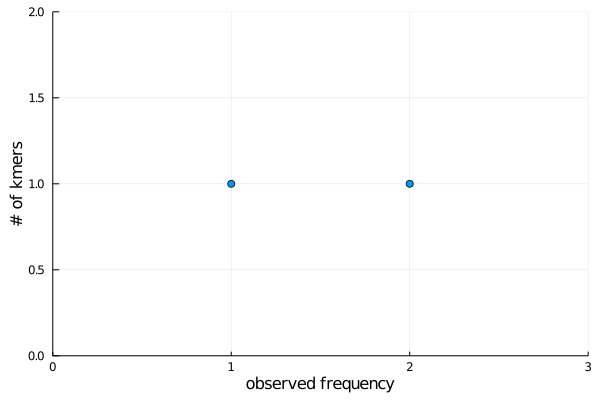

In [30]:
xs = collect(keys(kmer_counts_hist))
ys = collect(values(kmer_counts_hist))

StatsPlots.plot(
    xs,
    ys,
    xlims = (0, maximum(xs) + 1),
    ylims = (0, maximum(ys) + 1),
    seriestype = :scatter,
    legend = false,
    xlabel = "observed frequency",
    ylabel = "# of kmers"
)

In [31]:
graph = initialize_graph(observations, kmers, k)

(graph = {2, 2} undirected simple Int64 graph, edge_evidence = Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Array{NamedTuple{(:observation_index, :edge_index),Tuple{Int64,Int64}},1}}(Edge 1 => 2 => [(observation_index = 1, edge_index = 1)],Edge 2 => 2 => [(observation_index = 1, edge_index = 2)]))

In [32]:
for (k, vs) in graph.edge_evidence
    println(k)
    for v in vs
        println("\t$v")
    end
end

Edge 1 => 2
	(observation_index = 1, edge_index = 1)
Edge 2 => 2
	(observation_index = 1, edge_index = 2)


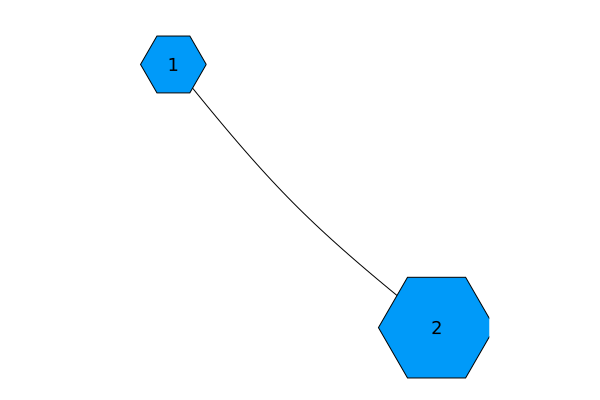

![](/assets/images/6456231177729018389.svg)

In [33]:
plot_graph(graph, kmers, counts)

In [34]:
outgoing_edge_probabilities, incoming_edge_probabilities = determine_edge_probabilities(graph.graph, kmers, graph.edge_evidence)

(
  [2, 1]  =  0.25
  [1, 2]  =  0.5
  [2, 2]  =  0.25, 
  [2, 1]  =  0.25
  [1, 2]  =  0.5
  [2, 2]  =  0.25)

In [35]:
shortest_paths = LightGraphs.enumerate_paths(LightGraphs.floyd_warshall_shortest_paths(graph.graph))

2-element Array{Array{Array{Int64,1},1},1}:
 [[], [1, 2]]
 [[2, 1], []]

In [159]:
observation = first(observations)

3nt DNA Sequence:
TCG

In [160]:
ORIENTED_KMER = NamedTuple{(:index, :orientation),Tuple{Int64,Union{Bool, Missing}}}

NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}

In [176]:
observed_path = [kmer.fw for kmer in BioSequences.each(KMER_TYPE, observation)]

3-element Array{BioSequences.Mer{BioSequences.DNAAlphabet{2},1},1}:
 T
 C
 G

In [177]:
kmer_likelihoods = Array{Float64}(undef, LightGraphs.nv(graph.graph), length(observed_path)) .= -Inf

2×3 Array{Float64,2}:
 -Inf  -Inf  -Inf
 -Inf  -Inf  -Inf

In [178]:
edit_distances = zeros(Int, LightGraphs.nv(graph.graph), length(observed_path))

2×3 Array{Int64,2}:
 0  0  0
 0  0  0

In [179]:
arrival_paths = Array{Union{Vector{ORIENTED_KMER}, Missing}}(missing, LightGraphs.nv(graph.graph), length(observed_path))

2×3 Array{Union{Missing, Array{NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}},1}},2}:
 missing  missing  missing
 missing  missing  missing

# initialization

In [180]:
observed_kmer = observed_path[1]

DNA 1-mer:
T

In [181]:
kmer_likelihoods[:, 1] .= counts ./ sum(counts)

2-element view(::Array{Float64,2}, :, 1) with eltype Float64:
 0.3333333333333333
 0.6666666666666666

In [182]:
for (kmer_index, kmer) in enumerate(kmers)
    alignment_result, orientation = assess_optimal_alignment(kmer, observed_kmer)
    
    for match in 1:alignment_result.total_matches
        kmer_likelihoods[kmer_index, 1] *= (1.0 - error_rate)
    end
    for edit in 1:alignment_result.total_edits
        kmer_likelihoods[kmer_index, 1] *= error_rate
    end
    arrival_paths[kmer_index, 1] = [(index = kmer_index, orientation = orientation)]
    edit_distances[kmer_index, 1] = alignment_result.total_edits
end

In [183]:
kmer_likelihoods[:, 1] ./= sum(kmer_likelihoods[:, 1])

2-element view(::Array{Float64,2}, :, 1) with eltype Float64:
 1.0
 0.0

In [184]:
kmer_likelihoods[:, 1] .= log.(kmer_likelihoods[:, 1])

2-element view(::Array{Float64,2}, :, 1) with eltype Float64:
   0.0
 -Inf

In [185]:
display(kmer_likelihoods)
display(arrival_paths)
display(edit_distances)

2×3 Array{Float64,2}:
   0.0  -Inf  -Inf
 -Inf   -Inf  -Inf

2×3 Array{Union{Missing, Array{NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}},1}},2}:
 NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((1, false))]    …  missing  missing
 NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((2, missing))]     missing  missing

2×3 Array{Int64,2}:
 0  0  0
 1  0  0

In [195]:
# for current_observation_index in 2:length(observed_path)
# for current_observation_index in 2:2
for current_observation_index in 3:3
    # current_observation_index = 3
    observed_kmer = observed_path[current_observation_index]
    observed_kmer_index = get_kmer_index(kmers, observed_kmer)
    println("current_observation_index = $(current_observation_index)")
    println("observed_kmer = $(observed_kmer)")
    for (current_kmer_index, current_kmer) in enumerate(kmers)
        println("\tcurrent_kmer_index = $(current_kmer_index)")
        println("\tcurrent_kmer = $(current_kmer)")
        for (previous_kmer_index, previous_kmer) in enumerate(kmers)
            println("\t\tprevious_kmer_index = $(previous_kmer_index)")
            println("\t\tprevious_kmer = $(previous_kmer)")

            previous_likelihood = kmer_likelihoods[previous_kmer_index, current_observation_index - 1]
            current_likelihood = kmer_likelihoods[current_kmer_index, current_observation_index]
            previous_arrival_path = arrival_paths[previous_kmer_index, current_observation_index - 1]
            if current_likelihood > previous_likelihood && !ismissing(previous_arrival_path)
                # we've determined that there is no way to get to this kmer being evaluated
                continue
            else
                if ismissing(previous_arrival_path)
                    previous_orientation = missing
                else
                    previous_orientation = last(arrival_paths[previous_kmer_index, current_observation_index - 1]).orientation
#                     @show previous_orientation
                end
                optimal_path_result =
                    find_optimal_path(observed_kmer,
                        previous_kmer_index,
                        previous_orientation,
                        current_kmer_index,
                        graph.graph, 
                        shortest_paths, 
                        kmers, 
                        counts,
                        outgoing_edge_probabilities, 
                        incoming_edge_probabilities,
                        error_rate)
                for propertyname in propertynames(optimal_path_result)
                    println("\t\t\t$propertyname = $(getproperty(optimal_path_result, propertyname))")
                end
                this_likelihood = previous_likelihood + log(optimal_path_result.path_likelihood)

                if this_likelihood > current_likelihood
                    kmer_likelihoods[current_kmer_index, current_observation_index] = this_likelihood
                    arrival_paths[current_kmer_index, current_observation_index] = optimal_path_result.oriented_path
                    previous_edit_distance = edit_distances[previous_kmer_index, current_observation_index - 1]
                    edit_distances[current_kmer_index, current_observation_index] = previous_edit_distance + optimal_path_result.edit_distance 
                end
            end
        end
    end
end

current_observation_index = 3
observed_kmer = G
	current_kmer_index = 1
	current_kmer = A
		previous_kmer_index = 1
		previous_kmer = A
"insertion" = "insertion"
this_oriented_path = NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((1, missing))]
this_likelihood = 0.0
this_edit_distance = 2
			oriented_path = NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[]
			path_likelihood = 0.0
			edit_distance = 0
		previous_kmer_index = 2
		previous_kmer = C
			oriented_path = NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[]
			path_likelihood = 0.0
			edit_distance = 0
	current_kmer_index = 2
	current_kmer = C
		previous_kmer_index = 1
		previous_kmer = A
			oriented_path = NamedTuple{(:index, :orientation),Tuple{Int64,Bool}}[(index = 1, orientation = 1), (index = 2, orientation = 0)]
			path_likelihood = 0.3333333333333333
			edit_distance = 0
		previous_kmer_inde

In [196]:
display(kmer_likelihoods)
display(arrival_paths)
display(edit_distances)

2×3 Array{Float64,2}:
   0.0  -Inf       -Inf
 -Inf    -1.09861   -2.89037

2×3 Array{Union{Missing, Array{NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}},1}},2}:
 NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((1, false))]    …  missing
 NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((2, missing))]     NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((2, true)), NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((2, false))]

2×3 Array{Int64,2}:
 0  0  0
 1  0  0

In [197]:
observation

3nt DNA Sequence:
TCG

In [198]:
z = reshape(Any[ismissing(arrival_paths[i]) ? missing : Any[Any[x.index, x.orientation] for x in arrival_paths[i]] for i in eachindex(arrival_paths)], size(arrival_paths))

2×3 Array{Any,2}:
 Any[Any[1, false]]    …  missing
 Any[Any[2, missing]]     Any[Any[2, true], Any[2, false]]

In [199]:
for row in eachrow(z)
    println(row)
end

Any[Any[Any[1, false]], missing, missing]
Any[Any[Any[2, missing]], Any[Any[1, false], Any[2, true]], Any[Any[2, true], Any[2, false]]]


In [200]:
for row in eachrow(arrival_paths)
    for cell in eachcol(row)
        println(cell)
    end
end

Union{Missing, Array{NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}},1}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((1, false))], missing, missing]
Union{Missing, Array{NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}},1}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((2, missing))], NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((1, false)), NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((2, true))], NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}[NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((2, true)), NamedTuple{(:index, :orientation),Tuple{Int64,Union{Missing, Bool}}}((2, false))]]
